#  Детектирование приступа эпилепсии по данным электроэнцефалограммы (EEG)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve

In [2]:
eeg = pd.read_csv('data.csv')
sns.set_style("whitegrid")

Набор данных представляет из себя 11500 записей с электроэнцефалограммой. Каждая запись соответствует какому-либо состоянию пациента в момент снятия показаний электоэнцефалограммы.   
В качестве задачи предплагается построение модели, которая умеет предсказывать по электроэнцефалограмме, был ли пристут эпилепсии или нет. Приступу эпилепсии соответствует класс 1 в y.    
Всего измерений 178, произведенных с частотой 1 Гц (1 раз в секунду).

In [3]:
N = 178

In [4]:
eeg = eeg.rename({'Unnamed: 0':'id'}, axis=1)

In [5]:
eeg = eeg.set_index('id')

In [6]:
eeg

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
id,,,,,,,,,,,,,,,,,,,,,
X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
X15.V1.924,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,15,16,12,5,-1,-18,-37,-47,-48,2
X19.V1.354,-47,-11,28,77,141,211,246,240,193,136,...,-65,-33,-7,14,27,48,77,117,170,1
X8.V1.28,14,6,-13,-16,10,26,27,-9,4,14,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5


## EDA

Посмотрим на то, как отличается поведение временных рядов для разных классов. Для этого усредним значения временных рядов для каждого класса.

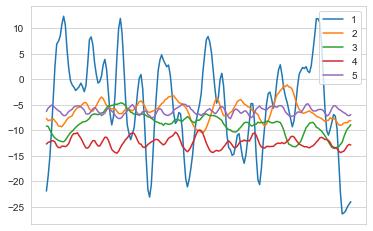

In [7]:
for i in range(1, 6):
    eeg[eeg['y'] == i].mean(axis=0, numeric_only=True).drop('y').plot(legend=True,label=i)
    plt.xticks([])

Видно, что когда у человека начинается приступ, значения электроэнцефалограммы сильнее разбросаны.

Преобразуем целевую переменную таким образом, чтоб наша модель занималась предсказанием только того, есть ли у пациента приступ эпилепсии или нет.

In [8]:
X = eeg.drop(['y'],axis=1)

In [9]:
y = (eeg['y'] == 1).astype('int64')

In [10]:
y

id
X21.V1.791    0
X15.V1.924    1
X8.V1.1       0
X16.V1.60     0
X20.V1.54     0
             ..
X22.V1.114    0
X19.V1.354    1
X8.V1.28      0
X10.V1.932    0
X16.V1.210    0
Name: y, Length: 11500, dtype: int64

In [11]:
X

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
id,,,,,,,,,,,,,,,,,,,,,
X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,...,8,-17,-15,-31,-77,-103,-127,-116,-83,-51
X15.V1.924,386,382,356,331,320,315,307,272,244,232,...,168,164,150,146,152,157,156,154,143,129
X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,29,57,64,48,19,-12,-30,-35,-35,-36
X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65
X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,10,4,2,-12,-32,-41,-65,-83,-89,-73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,20,15,16,12,5,-1,-18,-37,-47,-48
X19.V1.354,-47,-11,28,77,141,211,246,240,193,136,...,-94,-65,-33,-7,14,27,48,77,117,170
X8.V1.28,14,6,-13,-16,10,26,27,-9,4,14,...,-42,-65,-48,-61,-62,-67,-30,-2,-1,-8


([], [])

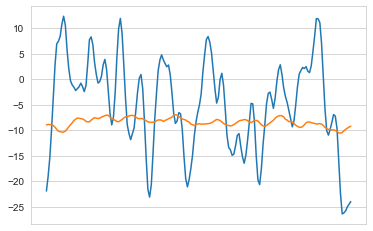

In [12]:
plt.plot(np.mean(X[y==1], axis=0))
plt.plot(np.mean(X[y==0], axis=0))
plt.xticks([])

Видно, что поведение электроэнцефалограмм с приступом и без него сильно различаются.

### Train-Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Baseline     
Для baseline возьмем RandomForest и предварительно отмасштабируем сырые данные. Посмотрим, что получится.

In [14]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('model',RandomForestClassifier(max_depth=5))])

In [15]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(max_depth=5))])

#### Accuracy:

In [16]:
pipeline.score(X_train, y_train)

0.9552173913043478

In [17]:
pipeline.score(X_test, y_test)

0.947391304347826

#### ROC-Curve:

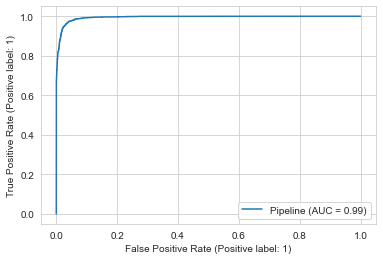

In [18]:
plot_roc_curve(pipeline, X_train, y_train)

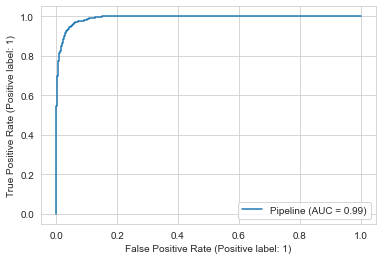

In [19]:
plot_roc_curve(pipeline, X_test, y_test)

В целом, уже хорошо получилось. Попробуем поэкспериментировать с различными преобразованиями над временными рядами.

## FFT-Features     
Применим быстрое преобразование Фурье к усредненным временным рядам по классам и посмотрим, различаются ли признаки в частотном пространстве.

In [20]:
from scipy.fft import fft, fftfreq

Пациенты, у которых 

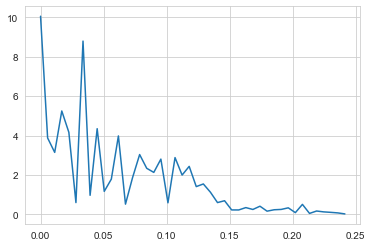

In [21]:
yf = fft(X_train[y_train==1].mean(axis=0).to_numpy())
xf = fftfreq(N)[:N//4]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//4]))

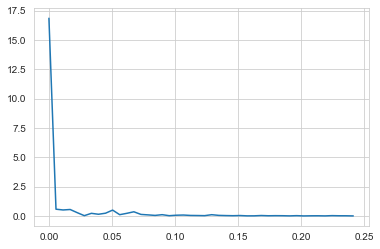

In [22]:
yf = fft(X_train[y_train==0].mean(axis=0).to_numpy())
xf = fftfreq(N)[:N//4]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//4]))

Видно, что в частотном пространстве разные классы весьма сильно отличаются. Попробуем отобрать признаки и посмотреть, как модель из baseline, будет работать на новых признаках.

In [23]:
X_train_fft =  2.0/N * np.abs(fft(X_train)[:, :N//4])
X_test_fft = 2.0/N * np.abs(fft(X_test)[:, :N//4])

In [24]:
X_train_fft.shape, X_test_fft.shape

((9200, 44), (2300, 44))

In [25]:
pipeline_fft = Pipeline([('scaler', StandardScaler()), 
                     ('model',RandomForestClassifier(max_depth=5))])

In [26]:
pipeline_fft.fit(X_train_fft, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(max_depth=5))])

#### Accuracy:

In [27]:
pipeline_fft.score(X_train_fft, y_train)

0.9802173913043478

In [28]:
pipeline_fft.score(X_test_fft, y_test)

0.9739130434782609

#### ROC-Curve:

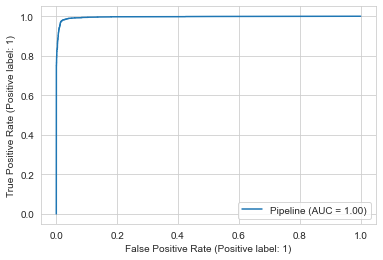

In [29]:
plot_roc_curve(pipeline_fft, X_train_fft, y_train)

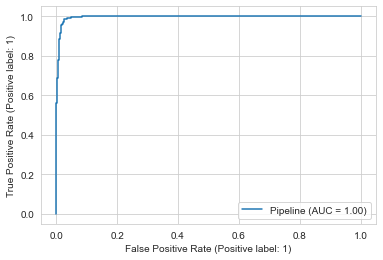

In [30]:
plot_roc_curve(pipeline_fft, X_test_fft, y_test)

В итоге, Фурье-преобразование позволило:    
1. Улучшить качество распознавания -- значение метрики accuracy на train и test выборке стало выше. ROC-кривая показывает, что вариант классификатора с Фурье-признаками более правильно работает, нежели чем с "сырым" рядом.
2. Уменьшить размерность признакового пространства, при этом качество не ухудшилось.

## Wavelet-Features
Продолжим эксперименты с временными рядами, вдруг, помимо частотных особенностей, у нас есть еще некоторые временные особенности в временных рядах.    
Для их исследования воспользуемся Вейвлет-преобразованиями. Получим новые Вейвлет-признаки, обучим на них модель из Baseline.

In [31]:
import pywt
import itertools
import scipy.stats
from collections import Counter
waveletname = 'rbio3.1'


Используется дискретное Вейвлет-преобразование, выделим новые признаки.    
При этом для Вейвлет-коэффициентов посчитаем различные дополнительные статистики, чтоб получить более выразительные признаки.

In [32]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(
        np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_new_features(dataset, labels, waveletname):
    new_features = []
    for signal_no in range(0, len(dataset)):
        features = []
        signal = dataset[signal_no, :]
        list_coeff = pywt.wavedec(signal, waveletname)
        for coeff in list_coeff:
            features += get_features(coeff)
        new_features.append(features)
    X = np.array(new_features)
    Y = np.array(labels)
    return X, Y

In [33]:
X_train_wavelet, Y_train_wavelet = get_new_features(X_train.to_numpy(), y_train, waveletname)
X_test_wavelet, Y_test_wavelet = get_new_features(X_test.to_numpy(), y_test, waveletname)

Посмотрим, как меняются значения признаков для целевого и нецелевого класса.

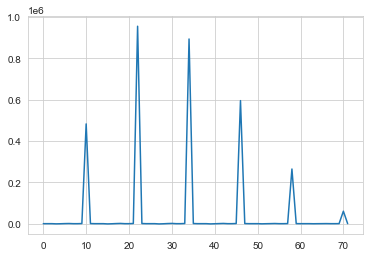

In [34]:
plt.plot(X_train_wavelet[Y_train_wavelet==1].mean(axis=0))

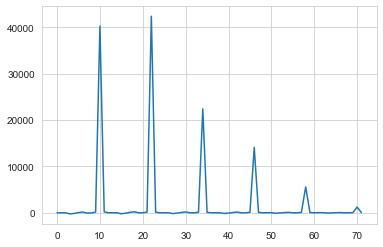

In [35]:
plt.plot(X_train_wavelet[Y_train_wavelet==0].mean(axis=0))

Различия видны, засунем все это в модель.

In [36]:
pipeline_wavelet = Pipeline([('scaler', StandardScaler()), 
                     ('model',RandomForestClassifier(max_depth=5))])

In [37]:
pipeline_wavelet.fit(X_train_wavelet, Y_train_wavelet)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(max_depth=5))])

#### Accuracy:

In [38]:
pipeline_wavelet.score(X_train_wavelet, Y_train_wavelet)

0.9860869565217392

In [39]:
pipeline_wavelet.score(X_test_wavelet, Y_test_wavelet)

0.9795652173913043

#### ROC-Curve:

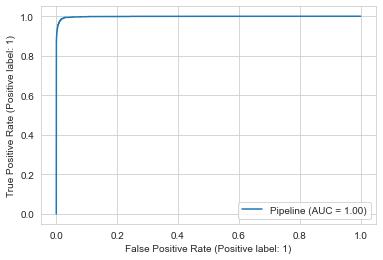

In [40]:
plot_roc_curve(pipeline_wavelet, X_train_wavelet, Y_train_wavelet)

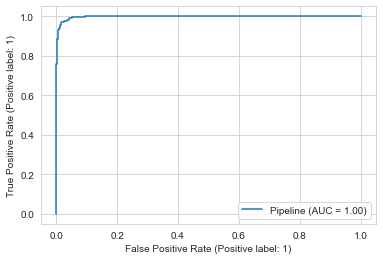

In [41]:
plot_roc_curve(pipeline_wavelet, X_test_wavelet, Y_test_wavelet)

Качество выше, чем для "сырых" рядов, однако, не сильно отличается от преобразования Фурье. Оценивая вид и поведение временных рядов, можно попробовать подобрать Вейвлет другой формы, который даст более хорошие признаки для нашего набора данных. Хотя, поведение ROC кривой, в случае использования Вейвлетов, лучше, чем просто используя коэффициенты Фурье-преобразования.

## TSFresh   
Последней частью экспериментального исследования является работа с библиотекой для автоматической генерации признаков для временных рядов -- TSFresh. Попробуем выделить с помощью нее признаки и обучить модель.

In [42]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [43]:
settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
#settings_efficient.update(settings.ComprehensiveFCParameters())
settings_efficient

{'linear_trend_timewise': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],
 'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'root_mean_square': None,
 'maximum': None,
 'minimum': None}

In [44]:
eeg_ts= eeg.reset_index()
eeg_ts

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [45]:
X_ts = extract_features(
    eeg_ts.drop('y',axis=1),
    column_id ='id',
    impute_function=impute, 
    default_fc_parameters=settings_efficient,
    n_jobs=6,
    disable_progressbar=True,
    show_warnings=False
)

In [46]:
y_ts = (eeg_ts.set_index('id')['y'] == 1).astype('int64')

In [47]:
X_sel_ts = select_features(X_ts, y_ts)

In [48]:
X_sel_ts

,X81__root_mean_square,X66__root_mean_square,X37__root_mean_square,X103__root_mean_square,X65__root_mean_square,X104__root_mean_square,X64__root_mean_square,X105__root_mean_square,X38__root_mean_square,X106__root_mean_square,...,X28__mean,X28__maximum,X28__minimum,X28__median,X28__sum_values,X31__maximum,X31__sum_values,X31__median,X31__minimum,X31__mean
X1.V1,50.0,7.0,38.0,29.0,13.0,5.0,1.0,21.0,24.0,33.0,...,5.0,5.0,5.0,5.0,5.0,25.0,25.0,25.0,25.0,25.0
X1.V1.1,15.0,52.0,94.0,24.0,24.0,22.0,1.0,24.0,107.0,40.0,...,-175.0,-175.0,-175.0,-175.0,-175.0,-47.0,-47.0,-47.0,-47.0,-47.0
X1.V1.10,54.0,19.0,23.0,98.0,22.0,108.0,32.0,100.0,13.0,89.0,...,-36.0,-36.0,-36.0,-36.0,-36.0,25.0,25.0,25.0,25.0,25.0
X1.V1.101,83.0,40.0,122.0,62.0,17.0,46.0,14.0,25.0,171.0,7.0,...,-49.0,-49.0,-49.0,-49.0,-49.0,-168.0,-168.0,-168.0,-168.0,-168.0
X1.V1.102,7.0,18.0,8.0,3.0,22.0,1.0,20.0,1.0,11.0,3.0,...,-26.0,-26.0,-26.0,-26.0,-26.0,-17.0,-17.0,-17.0,-17.0,-17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X9.V1.994,492.0,608.0,213.0,188.0,622.0,76.0,584.0,4.0,189.0,74.0,...,61.0,61.0,61.0,61.0,61.0,254.0,254.0,254.0,254.0,254.0
X9.V11,74.0,35.0,51.0,57.0,52.0,60.0,47.0,44.0,33.0,24.0,...,-89.0,-89.0,-89.0,-89.0,-89.0,-57.0,-57.0,-57.0,-57.0,-57.0
X9.V12,131.0,1.0,42.0,6.0,5.0,1.0,6.0,2.0,57.0,5.0,...,31.0,31.0,31.0,31.0,31.0,43.0,43.0,43.0,43.0,43.0
X9.V13,0.0,9.0,36.0,63.0,7.0,55.0,6.0,57.0,36.0,58.0,...,36.0,36.0,36.0,36.0,36.0,44.0,44.0,44.0,44.0,44.0


In [49]:
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_sel_ts, y, test_size=0.2, random_state=42, stratify=y)

In [50]:
X_train_ts.shape

(9200, 278)

In [51]:
pipeline_tsfresh = Pipeline([('scaler', StandardScaler()), 
                     ('model',RandomForestClassifier(max_depth=5))])

In [52]:
pipeline_tsfresh.fit(X_train_ts, y_train_ts)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(max_depth=5))])

#### Accuracy:

In [53]:
pipeline_tsfresh.score(X_train_ts, y_train_ts)

0.8

In [54]:
pipeline_tsfresh.score(X_test_ts, y_test_ts)

0.8

#### ROC-Curve:

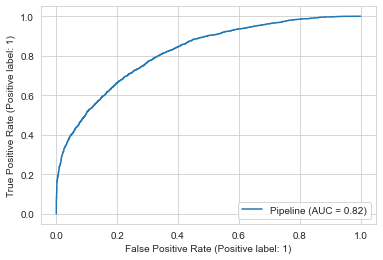

In [55]:
plot_roc_curve(pipeline_tsfresh, X_train_ts, y_train_ts)

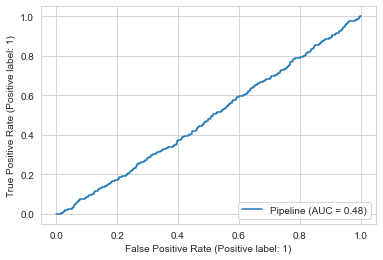

In [56]:
plot_roc_curve(pipeline_tsfresh, X_test_ts, y_test_ts)

Автоматическая генерация признаков показала плохие результаты. Особенно на тестовой выборке. Предположительно, это может быть связано с неверно выбранной подборкой признаков для генерации, однако на большей выборке признаков у меня не хватает ресурсов компьютера.     
По всей видимости, нужно правильным образом выбирать признаки, которые мы хотим посчитать для временного ряда более точно. Таким образом, автоматические признаки "из коробки" работают не очень хорошо для данной задачи, в отличие от Фурье и Вейвлет преобразований.
В качестве итога для данной задачи, можно сказать, что наиболее предпочтительным методом извлечения признака для данного набора данных является Вейвлет-преобразование.